In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd+'/../')

from util import *
import models

In [13]:
def plot_metrics(pruning_method='energy', arch = 'LeNet_5', stage = '0', NVM_COST=100):
    prefix = 'logs/{}/{}/stage_{}'.format(pruning_method, arch, stage)
    paths = [prefix+'.csv', prefix+'_pruning_order.csv', prefix+'_search_history.csv']
    df_0 = pd.read_csv(paths[0])
    df_1 = pd.read_csv(paths[1])
    df_2 = pd.read_csv(paths[2])
    print(df_0)
    df_data = df_0.loc[:, 'nvm_read_inputs':'vm_write_psum']
    df_data['pruned_ofm_element'] = df_0['pruned_ofm_element']
    df_energy_cost = df_data.copy()
    if pruning_method == 'energy':
        nvm = ['nvm_read_inputs', 'nvm_read_weights', 'nvm_jobs']
    elif pruning_method == 'intermittent':
        nvm = ['nvm_read_inputs', 'nvm_read_weights', 'nvm_jobs', 'nvm_read_psum', 'nvm_write_psum']
        df_energy_cost['nvm_read_psum'] = df_energy_cost['vm_read_psum']
        df_energy_cost['nvm_write_psum'] = df_energy_cost['vm_write_psum']
        df_energy_cost['nvm_jobs'] = df_energy_cost['vm_jobs'] + df_energy_cost['pruned_ofm_element']
    print(df_energy_cost)
        
    for item in nvm:
        df_energy_cost[item] = df_energy_cost[item] * NVM_COST

    df_energy_cost.plot(kind="bar",stacked=True,figsize=(10,8))
    plt.show()

    inputs_cost = df_energy_cost['nvm_read_inputs'] + df_energy_cost['vm_read_inputs']
    weights_cost = df_energy_cost['nvm_read_weights'] + df_energy_cost['vm_read_weights']
    if pruning_method == 'energy':
        psum_cost = df_energy_cost['nvm_jobs'] + df_energy_cost['vm_jobs'] + df_energy_cost['vm_read_psum'] + df_energy_cost['vm_write_psum']
    elif pruning_method == 'intermittent':
        psum_cost = df_energy_cost['nvm_jobs'] + df_energy_cost['nvm_read_psum'] + df_energy_cost['nvm_write_psum'] + df_energy_cost['vm_jobs'] + df_energy_cost['vm_read_psum'] + df_energy_cost['vm_write_psum']
    
    df_energy_class = pd.DataFrame()
    df_energy_class['inputs_cost'] = inputs_cost
    df_energy_class['weights_cost'] = weights_cost
    df_energy_class['psum_cost'] = psum_cost

    # add percenetage of each part
    df_total = 0
    for item in df_energy_class:
        df_total += df_energy_class[item]
    df_rel = df_energy_class[df_energy_class.columns[:]].div(df_total, 0) * 100

    print(df_rel)

    df_energy_class.plot(kind="bar",stacked=True,figsize=(10,8),title='Energy Cost Class')

    for n in df_rel:
        for i, (cs, ab, pc) in enumerate(zip(df_energy_class.iloc[:,:].cumsum(1)[n],df_energy_class[n], df_rel[n])):
            plt.text(i, cs - ab / 2, str(np.round(pc, 1)) + '%',va = 'center', ha = 'center')

    print('Pruning Order:')
    print(df_1)

def print_model_status(pruning_method='energy', arch = 'LeNet_5', stage = '0'):
    if arch == 'LeNet_5':
        model = models.LeNet_5(pruning_method)
    elif arch == 'SqueezeNet':
        model = models.SqueezeNet(pruning_method)
    else:
        print('[Error] Select correctly arch!')
        exit()
    
    pretrained_path = 'saved_models/'+pruning_method+'/'+arch+'/stage_'+stage+'.pth.tar'
    pretrained_model = torch.load(pretrained_path)
    best_acc = pretrained_model['acc']
    load_state(model, pretrained_model['state_dict'])                                                                                                                                                          
    if pruning_method and ('weights_pruned' in pretrained_model.keys()):
        model.weights_pruned = pretrained_model['weights_pruned']
    else:
        model.weights_pruned = None
    Prune_Op.print_info(model.weights_pruned)

In [16]:
pruning_method = 'energy'
arch = 'LeNet_5'

   node op_type  nvm_read_inputs  nvm_read_weights  nvm_jobs  vm_jobs  \
0     0    CONV            19600             22400      6272   156800   
1     1    CONV           156800             89600      3136   156800   
2     2      FC              256             65536       256     4096   
3     3      FC              256              2560        10      160   

   vm_read_weights  vm_read_inputs  vm_read_psum  vm_write_psum  nvm_access  \
0           156800          156800        313600         156800       49840   
1           627200          627200        313600         156800      255808   
2            65536           65536          8192           4096       66048   
3             2560            2560           320            160        2826   

   vm_access  pruned_ofm_element  
0     940800                   0  
1    1881600                   0  
2     147456                   0  
3       5760                   0  
   nvm_read_inputs  nvm_read_weights  nvm_jobs  vm_jobs  vm_rea

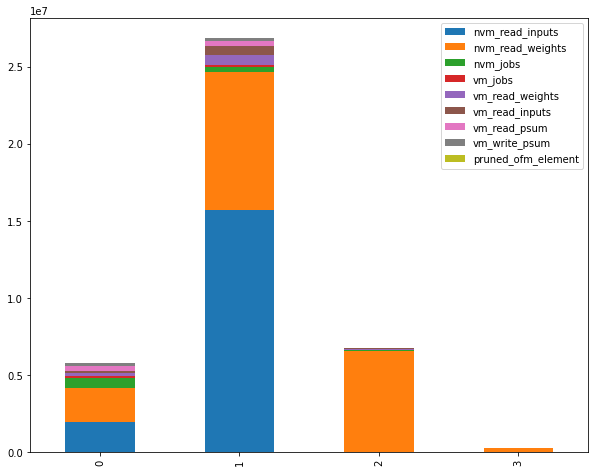

   inputs_cost  weights_cost  psum_cost
0    36.699029     41.553398  21.747573
1    60.767947     35.726210   3.505843
2     1.349712     98.028511   0.621777
3     9.765571     89.665696   0.568734
Pruning Order:
   0  1  2  3
0  3  0  2  1

------------------------------------------------------------------
- Intermittent-aware weight pruning info:
- Layer 0:         32 /        200 (16.0%) weights are pruned
- Layer 1:        832 /       3200 (26.0%) weights are pruned
- Layer 2:      16992 /      65536 (25.9%) weights are pruned
- Layer 3:          0 /       2560 ( 0.0%) weights are pruned
- Total  :      17856 /      71496 (25.0%) weights are pruned
------------------------------------------------------------------



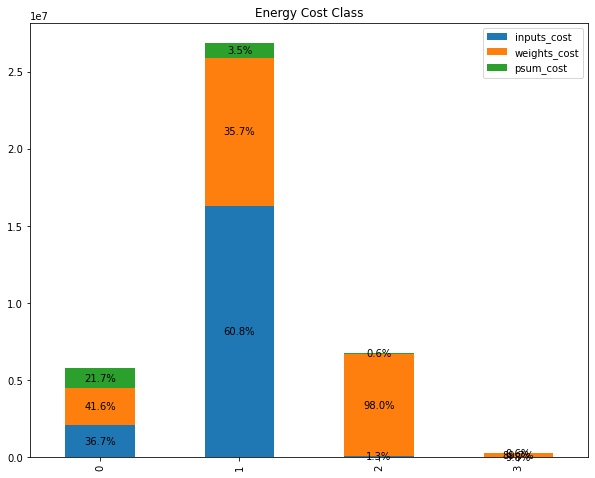

In [17]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='0')
print_model_status(pruning_method=pruning_method, arch=arch, stage='0')

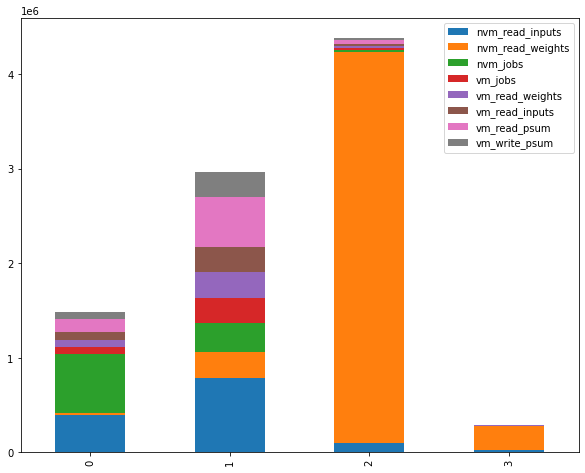

   inputs_cost  weights_cost  psum_cost
0    31.605244      6.556115  61.838641
1    35.447973     18.221891  46.330137
2     2.809072     94.738680   2.452248
3     9.260982     88.640827   2.098191
Pruning Order:
   0  1  2  3
0  3  0  1  2


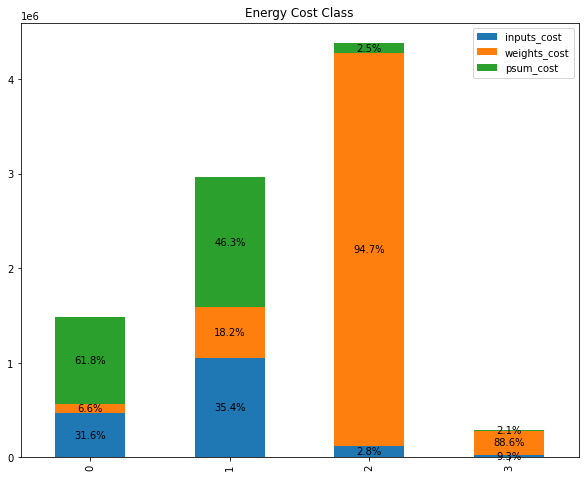

In [26]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='1')

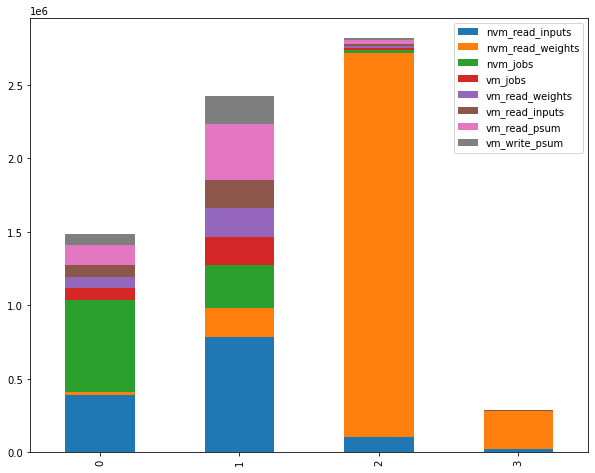

   inputs_cost  weights_cost  psum_cost
0    31.605244      6.556115  61.838641
1    40.284000     16.095199  43.620801
2     4.097297     93.167433   2.735269
3     9.260982     88.640827   2.098191
Pruning Order:
   0  1  2  3
0  3  0  1  2


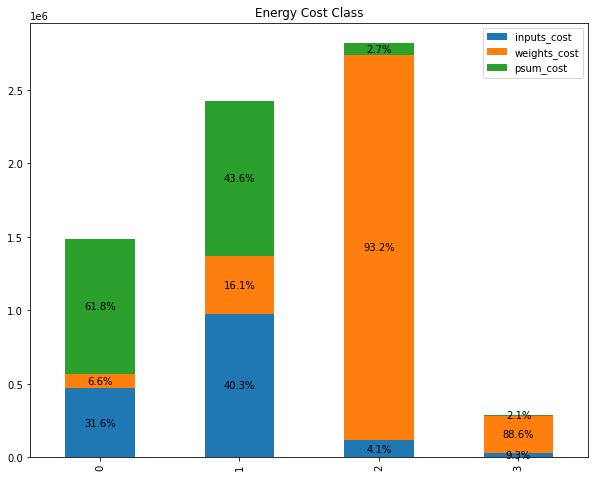

In [27]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='2')

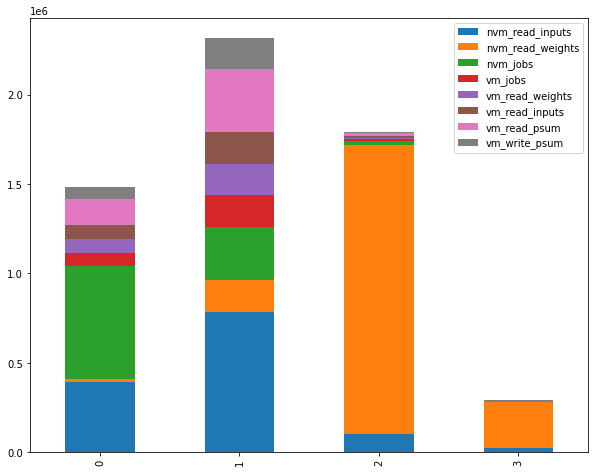

   inputs_cost  weights_cost  psum_cost
0    31.605244      6.556115  61.838641
1    41.537983     15.484389  42.977628
2     6.170876     90.734024   3.095101
3     9.260982     88.640827   2.098191
Pruning Order:
   0  1  2  3
0  3  0  2  1


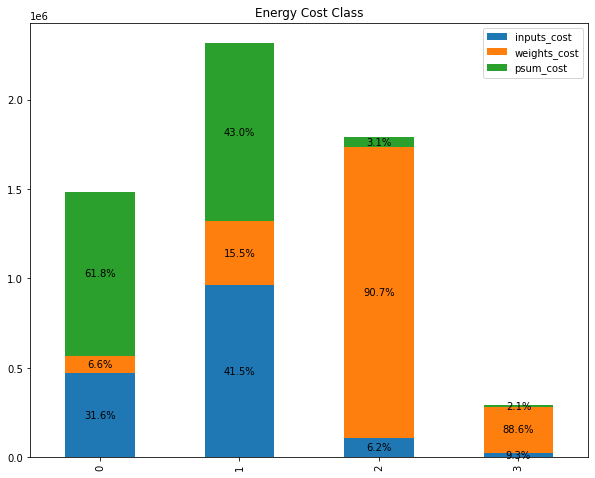

In [28]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='3')

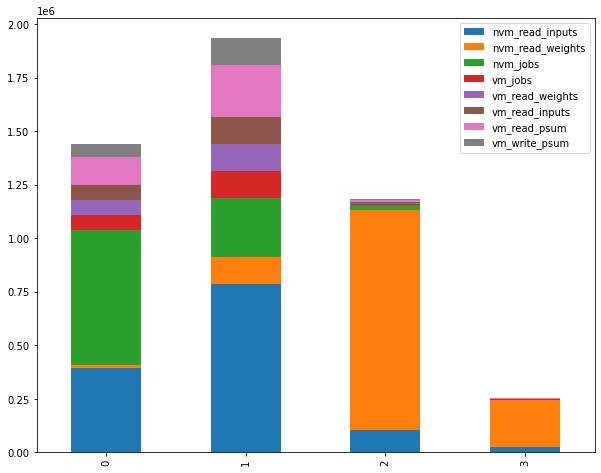

   inputs_cost  weights_cost  psum_cost
0    32.083366      6.142561  61.774074
1    47.054759     13.148389  39.796851
2     9.076463     87.391673   3.531864
3    10.546273     87.332622   2.121104
Pruning Order:
   0  1  2  3
0  3  2  0  1


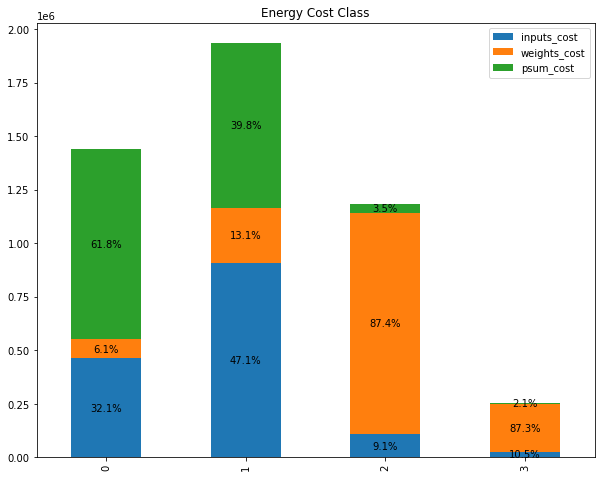

In [29]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='4')

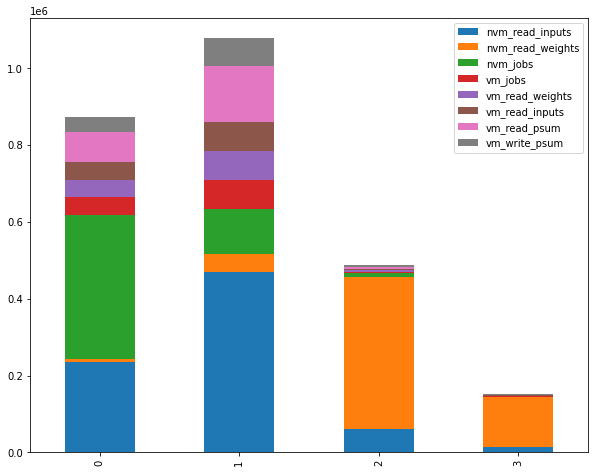

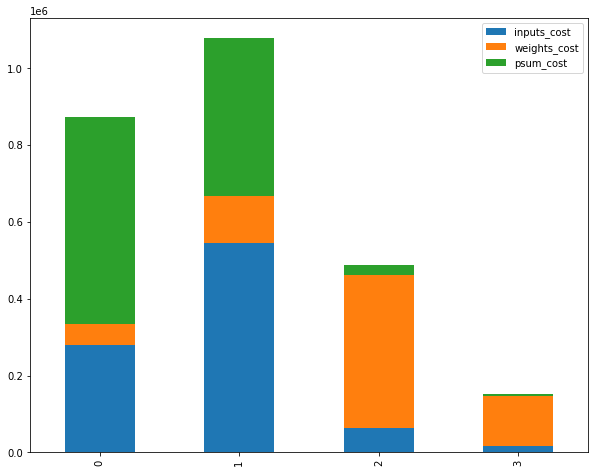

In [11]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='5')